# Анализ лояльности пользователей Яндекс Афиши
- Автор: Мухаджинов Ролан
- Дата: 20.11.25

### Цели и задачи проекта
**Цель:** Провести исследовательский анализ данных, чтобы понять, какие пользователи с большей вероятностью возвращаются на платформу и делают заказы повторно

**Задачи:**
1. Загрузить данные.
2. Провести предобработку данных.
3. Создать профиль искомого пользователя
4. Провести исследовательский анализ данных
5. Сформулировать выводы по проведённому анализу.

## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка



In [1]:
# Импорт необходимых библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# импорт sqlalchemy
try:
    from sqlalchemy import create_engine
except ModuleNotFoundError as e:
    !pip install sqlalchemy
    from sqlalchemy import create_engine
    print("Error was:", e)

%pip install psycopg2

# импорт phik
try:
    from phik import phik_matrix
except ModuleNotFoundError as e:
    !pip install phik
    from phik import phik_matrix
    print("Error was:", e)

display('succesfull')

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


'succesfull'

In [2]:
# Создание подключения к базе данных
db_config = {'user': 'praktikum_student', # имя пользователя
             'pwd': 'Sdf4$2;d-d30pp', # пароль
             'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
             'port': 6432, # порт подключения
             'db': 'data-analyst-afisha' # название базы данных
             }

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

engine = create_engine(connection_string)

In [3]:
# Создание запроса к БД с последующей загрузкой в датафрейм
query = '''
SELECT user_id, p.device_type_canonical, order_id, p.created_dt_msk AS order_dt, 
	p.created_ts_msk AS order_ts, p.currency_code, revenue, p.tickets_count, 
	EXTRACT(DAY FROM p.created_dt_msk - LAG(p.created_dt_msk) OVER (PARTITION BY p.user_id ORDER BY p.created_dt_msk)) AS days_since_prev, 
	e.event_id, e.event_name_code  AS event_name, p.service_name, event_type_main, r.region_name, c.city_name 
FROM afisha.purchases p 
JOIN afisha.events e USING (event_id)
JOIN afisha.city c USING (city_id)
JOIN afisha.regions r USING (region_id)
WHERE p.device_type_canonical IN ('mobile', 'desktop')
	and event_type_main != 'фильм'
order by user_id, created_dt_msk
'''

df = pd.read_sql_query(query, con=engine)

---

**Описание данных:** 
- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---




**Изучим общую информацию о данных:** 



In [4]:
# Использую ранее написанную функцию для быстрого обзора данных
def review_df(df, k=50):
    display('Быстрый обзор датафрейма:')
    
    display('-' * k)
    display('Первые 5 строк:', df.head())

    display('-' * k)
    display('info:')
    display(df.info())

    display('-' * k)
    display('Абсолютное количество пропусков:')
    na_abs = df.isna().sum().sort_values(ascending=False) 
    display(na_abs[na_abs > 0])
    
    display('-' * k)
    display('Относительное количество пропусков:')
    na_abs = df.isna().mean().sort_values(ascending=False) 
    display(na_abs[na_abs > 0])

    for column in df.columns:
        if 'int' in str(df[column].dtype):
            display('-' * k)
            df[column].plot(kind='hist', 
                           figsize=(7, 3), 
                           grid=True, 
                           ylabel='Количество', 
                           xlabel=column, 
                           title=f'Распределение значений столбца {column}')
            plt.show()

    display('-' * k)
    for column in df.columns:
        flag = 0
        if 'category' in str(df[column].dtype):
            if not flag:
                display('Категориальные значения:')
                flag = 1
            display('-' * k)
            display(df[column].unique().sort_values())
    if not flag:
        display('Категориальных значений не обнаружено')

    display('-' * k)
    display('Количество явных дубликатов:', int(df.duplicated().sum()))

'Быстрый обзор датафрейма:'

'----------------------------------------------------------------------------------------------------'

'Первые 5 строк:'

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,service_name,event_type_main,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,Край билетов,театр,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,Мой билет,выставки,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,За билетом!,другое,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,Лови билет!,другое,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,Билеты без проблем,стендап,Озернинский край,Родниковецк


'----------------------------------------------------------------------------------------------------'

'info:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  service_name           290611 non-null  object        
 12  event_type_main        290611 non-null  obje

None

'----------------------------------------------------------------------------------------------------'

'Абсолютное количество пропусков:'

days_since_prev    21933
dtype: int64

'----------------------------------------------------------------------------------------------------'

'Относительное количество пропусков:'

days_since_prev    0.075472
dtype: float64

'----------------------------------------------------------------------------------------------------'

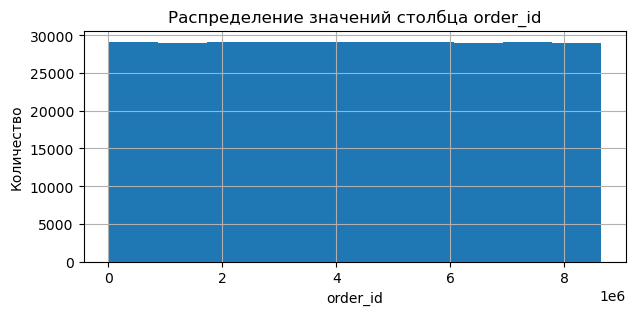

'----------------------------------------------------------------------------------------------------'

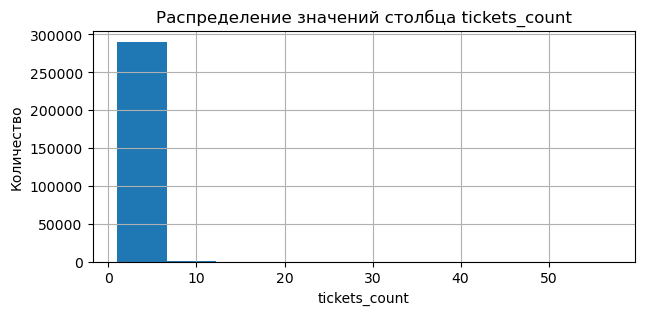

'----------------------------------------------------------------------------------------------------'

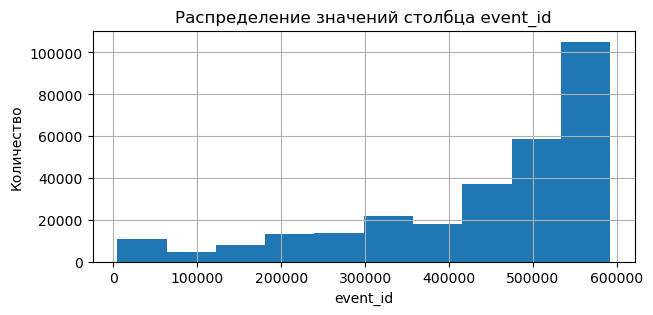

'----------------------------------------------------------------------------------------------------'

'Категориальных значений не обнаружено'

'----------------------------------------------------------------------------------------------------'

'Количество явных дубликатов:'

0

In [5]:
review_df(df, 100)

**Промежуточный вывод о данных:**
- Объем данных: 290 000 строк и 15 стобцов
- Типы данных автоматически определены верно. Для столбцов `tickets_count` и некоторых других понизим разрядность
- Пропущенные значения в единственном столюце `days_since_prev` - 22000 строк или 7.5% данных
- Явных дубликатов в данных нет

---

###  2. Предобработка данных

**Переведем денные о выручке в рубли:** 

Для этого используем датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`

Результаты преобразования сохраним в новый столбец `revenue_rub`.

---


In [6]:
currency_data = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

In [7]:
currency_data.head()

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [8]:
currency_data['data'] = pd.to_datetime(currency_data['data'])

In [9]:
# Объединияем датафреймы
currency_data = currency_data.rename(columns={'data': 'order_dt'})
df = df.merge(currency_data[['order_dt', 'curs']], on='order_dt', how='left')

# создаем столбец revenue_rub
df['revenue_rub'] = df['revenue']
mask = df['currency_code'] == 'kzt'
df.loc[mask, 'revenue_rub'] *= df.loc[mask, 'curs'] / 100

# удаляем ненужный столбец после объединения
df = df.drop(columns=['curs'])

display(df[df['currency_code'] == 'kzt'].head(2))

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,service_name,event_type_main,region_name,city_name,revenue_rub
70,0033403583a55ed,mobile,7850214,2024-09-17,2024-09-17 16:52:06,kzt,518.10,4,20.0,559919,f5ec2467-ee48-42f3-89a0-a2d90d1d6fce,Билеты без проблем,другое,Верхоречная область,Серебрянка,98.503762
89,0040e12d70fae81,desktop,8634925,2024-09-02,2024-09-02 19:49:14,kzt,347.18,3,39.0,559476,61ec7c0e-ea0c-4a3e-a63a-09cbe1bc6177,Билеты без проблем,другое,Верхоречная область,Серебрянка,65.731589


---

**Задача 2.2:**

- **Пропущенные значения:** пропуски присутствуют только в столбце `days_since_prev`, они означают, что данный заказ - первый у конкретного пользователя. Поэтому как-либо заполнить эти пропуски мы не можем

---

In [10]:
# сохраним объем данных перед предобработкой
rows = df.shape[0]
rows

290611

In [11]:
df['tickets_count'] = pd.to_numeric(df['tickets_count'], downcast='integer')

In [12]:
for col in ['device_type_canonical', 'currency_code', 'service_name', 'event_type_main']:
    df[col] = df[col].astype('category')

**Проверим распределения численных данных:**

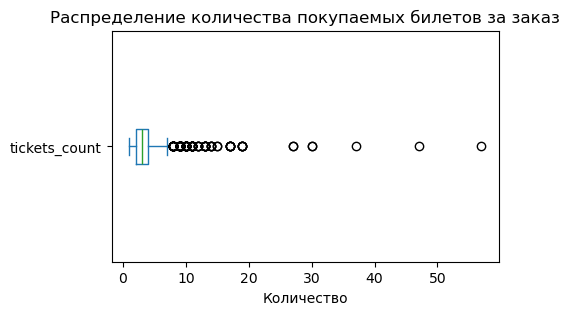

In [13]:
plt.figure(figsize=(5, 3))
df['tickets_count'].plot(kind='box', vert=False)

plt.title('Распределение количества покупаемых билетов за заказ')
plt.xlabel('Количество')

plt.show()

Присутствуют выбросы, экспериментально выберем такое значение, чтобы отсечь только выбросы:

In [14]:
df = df[df['tickets_count'] <= 6]

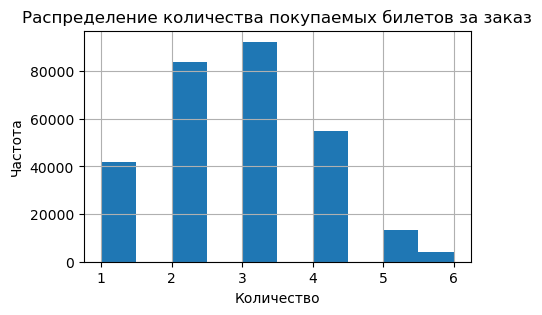

In [15]:
plt.figure(figsize=(5, 3))
df['tickets_count'].plot(kind='hist',
                        bins=10, 
                        grid=True)

plt.title('Распределение количества покупаемых билетов за заказ')
plt.xlabel('Количество')
plt.ylabel('Частота')

plt.show()

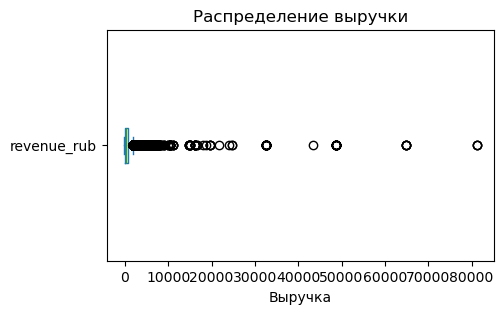

In [16]:
plt.figure(figsize=(5, 3))
df['revenue_rub'].plot(kind='box', vert=False)

plt.title('Распределение выручки')
plt.xlabel('Выручка')

plt.show()

Присутствуют выбросы, отсечем их до 99 процентиля.

In [17]:
df = df[df['revenue'] <= df['revenue'].quantile(0.99)]

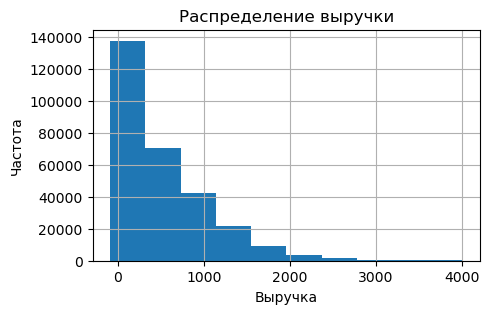

In [18]:
plt.figure(figsize=(5, 3))
df['revenue_rub'].plot(kind='hist',
                        bins=10, 
                        grid=True)

plt.title('Распределение выручки')
plt.xlabel('Выручка')
plt.ylabel('Частота')

plt.show()

В данных присутствуют отричательные значения. Трудно предположить природу их появления, отсечем их

In [19]:
df = df[df['revenue'] >= 0]

Рассмотрим `event_type_main`:

C:\Users\mrrol\AppData\Local\Temp\ipykernel_20168\1156025766.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('event_type_main')['order_id'].count().sort_values(ascending=False).plot(kind='bar',


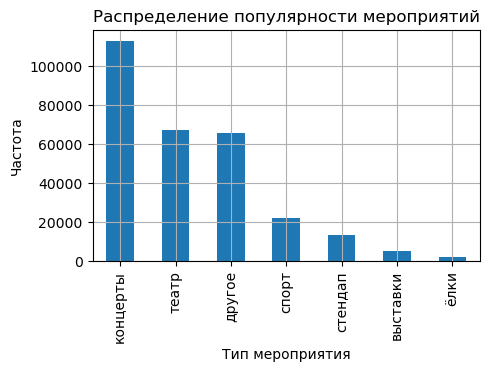

In [69]:
plt.figure(figsize=(5, 3))
df.groupby('event_type_main')['order_id'].count().sort_values(ascending=False).plot(kind='bar',
                        grid=True)

plt.title('Распределение популярности мероприятий')
plt.xlabel('Тип мероприятия')
plt.ylabel('Частота')

plt.show()

In [21]:
rows_deleted = rows - df.shape[0]
rows_deleted

3472

**Промежуточный вывод после предобработки:**
- Создан новый столбец `revenue_rub` с выручкой, выраженной в рублях для всех данных
- Пропуски обнаружены только в столбце `days_since_prev`
- Оптимизация типов: уменьшена разрядность для `tickets_count`, категоризированы `device_type_canonical`, `currency_code`, `service_name`, `event_type_main`
- Выбросы: Удалены значения ниже 7 для `tickets_count`, значения ниже 99 процентиля и ниже 0 для `revenue_rub` (в сумме 3472 строки или <1.5% данных)

---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


In [22]:
grpd_df = df.sort_values(by='order_ts').groupby('user_id')
agg_df = grpd_df.agg(first_dt=('order_dt', 'min'), 
             last_dt=('order_dt', 'max'), 
             first_device=('device_type_canonical', 'first'), 
             first_region=('region_name', 'first'), 
             first_service=('service_name', 'first'), 
             first_genre=('event_type_main', 'first'), 
             total_orders=('order_id', 'count'), 
             avg_revenue=('revenue_rub', 'mean'), 
             avg_tickets=('tickets_count', 'mean')
            )
agg_df['avg_time_btw_orders'] = (agg_df['last_dt'] - agg_df['first_dt']) / agg_df['total_orders']

agg_df['is_two'] = agg_df['total_orders'] >= 2
agg_df['is_five'] = agg_df['total_orders'] >= 5

agg_df.head()

,first_dt,last_dt,first_device,first_region,first_service,first_genre,total_orders,avg_revenue,avg_tickets,avg_time_btw_orders,is_two,is_five
user_id,,,,,,,,,,,,
0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,1,1521.940000,4.000000,0 days 00:00:00,False,False
0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,Мой билет,выставки,2,774.010000,3.000000,37 days 12:00:00,True,False
000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,Лови билет!,другое,3,767.213333,2.666667,34 days 00:00:00,True,False
00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,Край билетов,театр,1,917.830000,4.000000,0 days 00:00:00,False,False
000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,Лучшие билеты,театр,2,61.310000,1.500000,8 days 00:00:00,True,False


---

**Репрезентативность данных и аномалии** 

Используя данные о профилях пользователей, рассчитаем:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучим статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

In [23]:
total_users = agg_df.shape[0]
print('total users: ', total_users)

avg_revenue = (agg_df['total_orders'] * agg_df['avg_revenue']).sum() / agg_df['total_orders'].sum()
print('avg revenue total: ', avg_revenue)

is_two_share = agg_df['is_two'].mean()
print('is_two share: ', is_two_share)

is_five_share = agg_df['is_five'].mean()
print('is_five share: ', is_five_share)

total users:  21745
avg revenue total:  527.9723424250527
is_two share:  0.6174292940905955
is_five share:  0.2907794895378248


In [24]:
agg_df[['total_orders', 'avg_tickets', 'avg_time_btw_orders']].describe()

,total_orders,avg_tickets,avg_time_btw_orders
count,21745.000000,21745.000000,21745
mean,13.204829,2.745144,6 days 12:20:43.241804184
std,121.941571,0.910968,10 days 22:48:46.817855509
min,1.000000,1.000000,0 days 00:00:00
25%,1.000000,2.000000,0 days 00:00:00
50%,2.000000,2.750000,0 days 00:00:00
75%,5.000000,3.111111,9 days 09:13:50.769230769
max,10179.000000,6.000000,74 days 00:00:00


**Надлюдения:**
- Имеем 21745 пользователей
- Один из пользователей совершил 10179 заказов - аномалия. Удалим ее из данных
- Распределение среднего количества покупаемых билетов нормальное



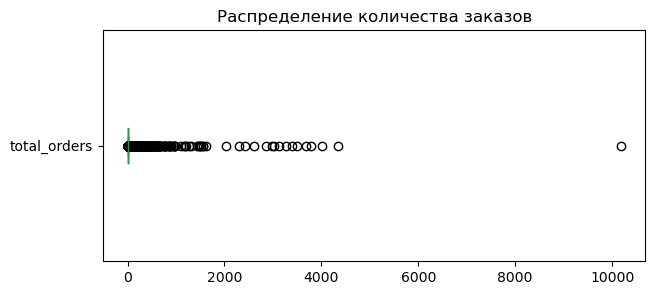

In [25]:
plt.figure(figsize=(7, 3))
agg_df['total_orders'].plot(kind='box', 
           vert=False)
plt.title('Распределение количества заказов')
plt.show()

Имеем большое количество выбросов-аномалий. Исключим их из анализа

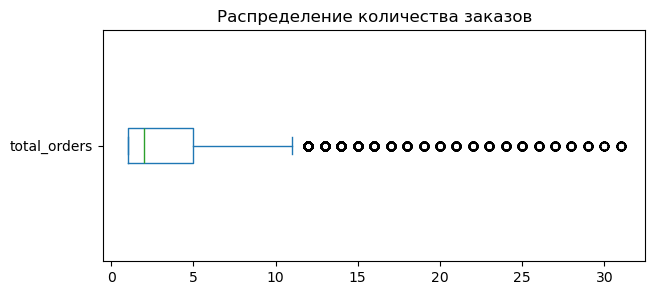

In [26]:
agg_df = agg_df[agg_df['total_orders'] < agg_df['total_orders'].quantile(0.95)]

plt.figure(figsize=(7, 3))
agg_df['total_orders'].plot(kind='box', 
           vert=False)
plt.title('Распределение количества заказов')
plt.show()

Аномалии удалены, выведем статистические показатели снова:

In [27]:
total_users = agg_df.shape[0]
print('total users: ', total_users)

avg_revenue = (agg_df['total_orders'] * agg_df['avg_revenue']).sum() / agg_df['total_orders'].sum()
print('avg revenue total: ', avg_revenue)

is_two_share = agg_df['is_two'].mean()
print('is_two share: ', is_two_share)

is_five_share = agg_df['is_five'].mean()
print('is_five share: ', is_five_share)

total users:  20655
avg revenue total:  550.557889457403
is_two share:  0.5972403776325345
is_five share:  0.2533526991043331


In [28]:
agg_df[['total_orders', 'avg_tickets', 'avg_time_btw_orders']].describe()

,total_orders,avg_tickets,avg_time_btw_orders
count,20655.000000,20655.000000,20655
mean,4.049237,2.745478,6 days 17:53:49.983682963
std,5.108700,0.932526,11 days 04:25:43.621399738
min,1.000000,1.000000,0 days 00:00:00
25%,1.000000,2.000000,0 days 00:00:00
50%,2.000000,2.750000,0 days 00:00:00
75%,5.000000,3.166667,10 days 00:00:00
max,31.000000,6.000000,74 days 00:00:00


- Удалено 1090 пользователей
- Распределение количества купленных бидетов смещено влево (среднее - 2 / медиана - 4)

---

### 4. Исследовательский анализ данных

Исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


In [29]:
by_event_type = agg_df.groupby('first_genre')
by_event_type_distr = by_event_type.agg(count=('first_dt', 'count')).sort_values(by='count', ascending=False)
by_event_type_distr['share'] = by_event_type_distr / total_users
by_event_type_distr

C:\Users\mrrol\AppData\Local\Temp\ipykernel_20168\3250102146.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  by_event_type = agg_df.groupby('first_genre')


,count,share
first_genre,,
концерты,9007,0.436069
другое,5201,0.251803
театр,4109,0.198935
стендап,1074,0.051997
спорт,770,0.037279
выставки,400,0.019366
ёлки,94,0.004551


Чаще всего пользователи покупают билеты на концерты

In [30]:
by_device_type = agg_df.groupby('first_device')
by_device_type_distr = by_device_type.agg(count=('first_region', 'count')).sort_values(by='count', ascending=False)
by_device_type_distr['share'] = by_device_type_distr / total_users
by_device_type_distr

C:\Users\mrrol\AppData\Local\Temp\ipykernel_20168\1484620813.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  by_device_type = agg_df.groupby('first_device')


,count,share
first_device,,
mobile,17155,0.83055
desktop,3500,0.16945


83% пользователей совершают первые покупки с мобильных устройств

In [31]:
by_region = agg_df.groupby('first_region')
by_region_distr = by_region.agg(count=('first_dt', 'count')).sort_values(by='count', ascending=False)
by_region_distr['share'] = by_region_distr / total_users
by_region_distr

,count,share
first_region,,
Каменевский регион,6846,0.331445
Североярская область,3613,0.174921
Широковская область,1196,0.057904
Озернинский край,665,0.032196
Малиновоярский округ,531,0.025708
...,...,...
Залесский край,2,0.000097
Верхозёрский край,1,0.000048
Светолесский край,1,0.000048


33% пользователей совершили первую покупку из Каменевского региона, далее Североярская область (17%), Широковская (6%)

In [32]:
by_service = agg_df.groupby('first_service')
by_service_distr = by_service.agg(count=('first_dt', 'count')).sort_values(by='count', ascending=False)
by_service_distr['share'] = by_service_distr / total_users
by_service_distr

C:\Users\mrrol\AppData\Local\Temp\ipykernel_20168\2887274788.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  by_service = agg_df.groupby('first_service')


,count,share
first_service,,
Билеты без проблем,4955,0.239893
Лови билет!,2728,0.132075
Мой билет,2655,0.128540
Билеты в руки,2428,0.117550
Облачко,2125,0.102881
Весь в билетах,1252,0.060615
Лучшие билеты,1137,0.055047
Прачечная,559,0.027064
Край билетов,442,0.021399


Лидируют "Билеты без проблем" - 24% первых покупок, "Лови билет" - 13% и "Мой билет" - 13%. 

Присутствуют операторы, не имеющие "новых" покупателей вовсе

В целом распределение по категориям неравномерно, по всем признакам есть выраженные "точки входа"

---

**Для каждого сегмента вычислим долю пользователей, совершивших два и более заказа** 

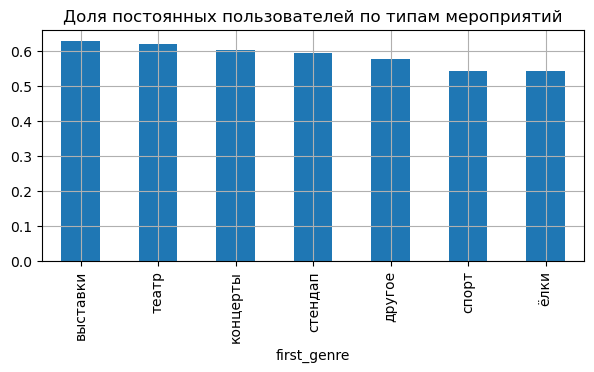

In [33]:
by_event_type['is_two'].mean().sort_values(ascending=False).plot(kind='bar', 
                                                                 grid=True, 
                                                                 figsize=(7, 3))

plt.title('Доля постоянных пользователей по типам мероприятий')
plt.show()

Доля постоянных пользователей не сильно зависит от категории первого мероприятия - варьируется от 0.54 до 0.62. 

Больше всего на выставках, меньше всего на ёлках

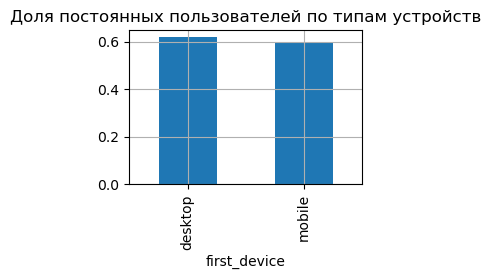

In [34]:
by_device_type['is_two'].mean().sort_values(ascending=False).plot(kind='bar', 
                                                                 grid=True, 
                                                                 figsize=(3, 2))

plt.title('Доля постоянных пользователей по типам устройств')
plt.show()

Разница также минимальна

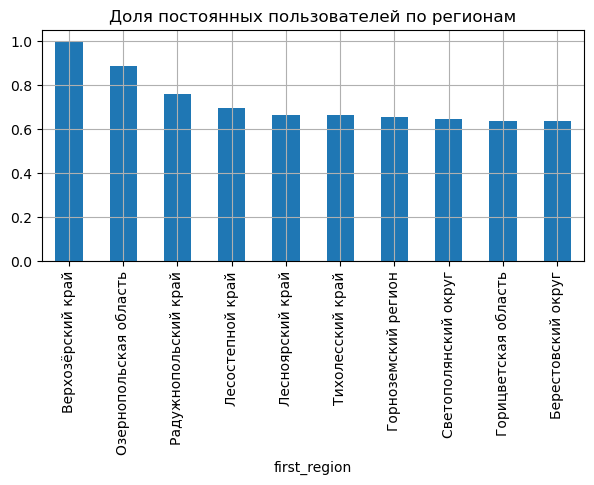

In [35]:
by_region['is_two'].mean().sort_values(ascending=False).head(10).plot(kind='bar', 
                                                                 grid=True, 
                                                                 figsize=(7, 3))

plt.title('Доля постоянных пользователей по регионам')
plt.show()

Единственный пользователь Верхозерского края оказался постоянным. В целом можно сказать, что регион не влияет на возврат пользователя

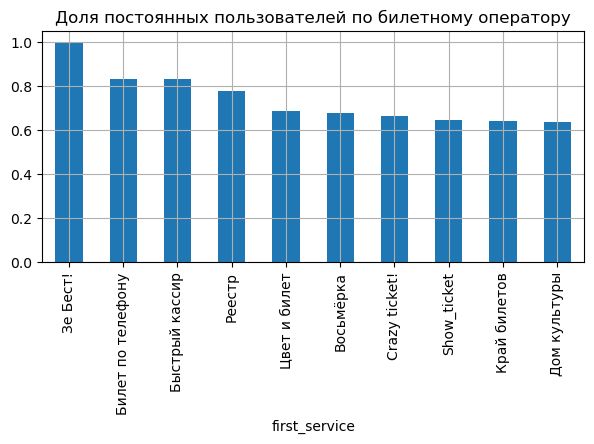

In [36]:
by_service['is_two'].mean().sort_values(ascending=False).head(10).plot(kind='bar', 
                                                                 grid=True, 
                                                                 figsize=(7, 3))

plt.title('Доля постоянных пользователей по билетному оператору')
plt.show()

Лидирующие 4 оператора имеют мало пользователей в целом, что влияет на результат. 

Среди популярных операторов - выделяющихся нет

---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверим продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

**Гипотеза 1**

Нет, это не так. Пользователи, выбравшие концерты, возвращаются немного чаще, чем выбравшие спорт, однако лидируют выбравшие выставки и театры

**Гипотеза 2**

Нет, это не так. Регионы с наибольшей долей повторных заказов имеют совсем небольшое количество пользователей, но это справедливо только в одну сторону - не все регионы с малым количеством пользователей имеют высокую долю возвращающихся.

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучим количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Проследим связь между средней выручкой сервиса с заказа и повторными заказами** 



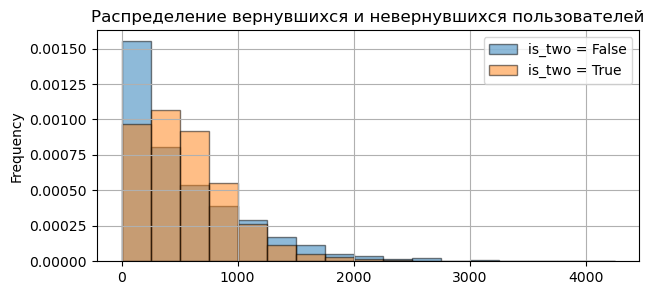

In [37]:
for i in range(2):
    agg_df.loc[agg_df['is_two'] == i, 'avg_revenue'].plot(kind='hist', 
                                                          bins=range(0, 4500, 250),
                                                          alpha=0.5, 
                                                          legend=True, 
                                                          label=f'is_two = {bool(i)}', 
                                                          edgecolor='black', 
                                                          density=True, 
                                                          grid=True, 
                                                          figsize=(7, 3)
                                                         )

plt.title('Распределение вернувшихся и невернувшихся пользователей')
plt.show()

Средняя выручка с билета у пользователей, совершивших одну покупку, чаще всего наблюдаются значения до 250 рублей. 

Постоянные пользователи чаще выбирают билеты до 1000 рублей, но реже более 1000 рублей, чем первые. 

---

**Сравним распределение по средней выручке с заказа в двух группах пользователей**

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

---


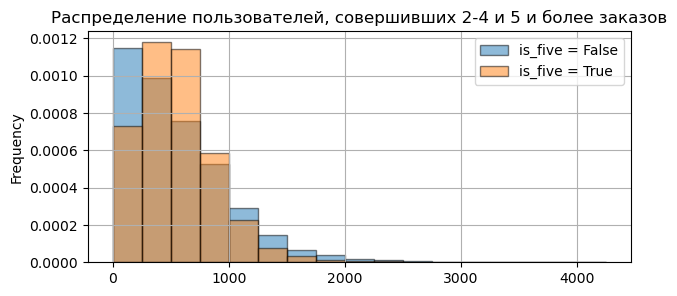

In [38]:
for i in range(2):
    agg_df.loc[(agg_df['is_two']) & (agg_df['is_five'] == i), 'avg_revenue'].plot(kind='hist', 
                                                                                  bins=range(0, 4500, 250),
                                                                                  alpha=0.5, 
                                                                                  legend=True, 
                                                                                  label=f'is_five = {bool(i)}', 
                                                                                  edgecolor='black', 
                                                                                  density=True, 
                                                                                  grid=True, 
                                                                                  figsize=(7, 3)
                                                                                 )

plt.title('Распределение пользователей, совершивших 2-4 и 5 и более заказов')
plt.show()

Совершившие 2-4 покупки чаще тратят менее 250 и более 1000 рублей

Совершившие 5 и более покупок чаще покупают билеты от 250 до 1000 рублей

---

**Проанализируем влияние среднего количества билетов в заказе на вероятность повторной покупки**

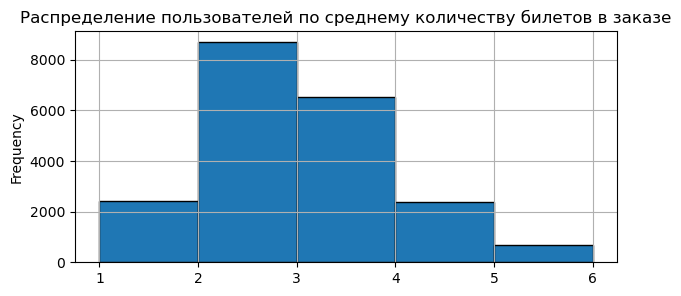

In [39]:
agg_df['avg_tickets'].plot(kind='hist', 
                           bins=range(1, 7),
                           edgecolor='black', 
                           grid=True, 
                           figsize=(7, 3)
                          )

plt.title('Распределение пользователей по среднему количеству билетов в заказе')
plt.show()

Больше всего пользователей, покупающих по 2-3 билета, далее - 1 и 4, реже - 5+

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучим временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Проанализируем, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей**


In [40]:
agg_df['first_day_of_week'] = agg_df['first_dt'].dt.weekday

by_day_of_week = agg_df.groupby('first_day_of_week').agg(count=('first_dt', 'count'), 
                                                         is_two_share=('is_two', 'mean'))

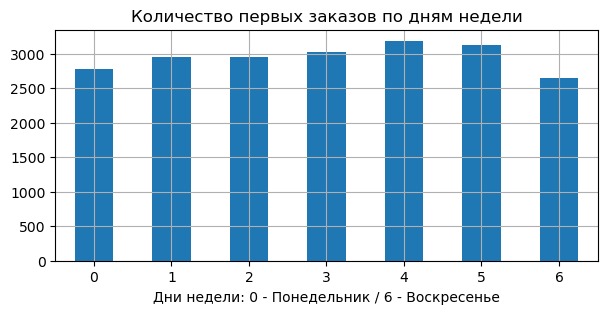

In [41]:
by_day_of_week['count'].plot(kind='bar', 
                             grid=True, 
                             figsize=(7, 3), 
                             rot=0
                            )

plt.title('Количество первых заказов по дням недели')
plt.xlabel('Дни недели: 0 - Понедельник / 6 - Воскресенье')
plt.show()

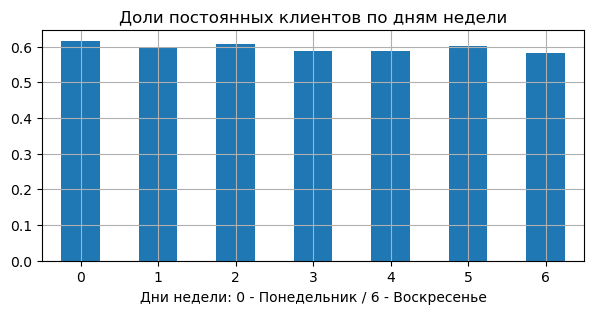

In [42]:
by_day_of_week['is_two_share'].plot(kind='bar', 
                             grid=True, 
                             figsize=(7, 3), 
                             rot=0
                            )

plt.title('Доли постоянных клиентов по дням недели')
plt.xlabel('Дни недели: 0 - Понедельник / 6 - Воскресенье')
plt.show()

Количество первых заказов растет от понедельника до пятницы/субботы, затем резко снижается в воскресенье.

При этом доля постоянных клиентов не зависит от дня недели

---

**Изучите, как средний интервал между заказами влияет на удержание клиентов.**

In [50]:
for_2_4 = agg_df.loc[agg_df['is_two'] & (agg_df['is_five'] == False), 'avg_time_btw_orders'].mean()
for_5 = agg_df.loc[agg_df['is_five'], 'avg_time_btw_orders'].mean()

print('Среднее время между заказами')
print(f'Для совершивших 2-4 заказа: {for_2_4}')
print(f'Для совершивших 5 и более заказов: {for_5}')

Среднее время между заказами
Для совершивших 2-4 заказа: 12 days 12:21:39.507250457
Для совершивших 5 и более заказов: 9 days 15:19:29.522830422


Более постоянные клиенты имеют более короткий интервал между покупками билетов

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучим, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используем универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Проведите корреляционный анализ:**
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

In [52]:
agg_df.columns

Index(['first_dt', 'last_dt', 'first_device', 'first_region', 'first_service',
       'first_genre', 'total_orders', 'avg_revenue', 'avg_tickets',
       'avg_time_btw_orders', 'is_two', 'is_five', 'first_day_of_week'],
      dtype='object')

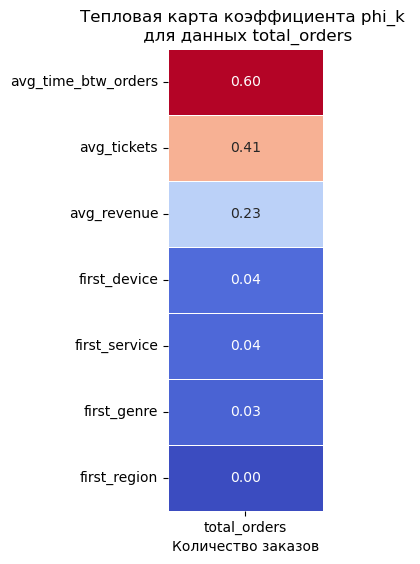

In [56]:
agg_df['avg_time_btw_orders'] = pd.to_numeric(agg_df['avg_time_btw_orders']) / (24 * 3600)

to_corr_columns = ['first_device', 'first_region', 'first_service', 'first_genre', 'total_orders', 
                   'avg_revenue', 'avg_tickets', 'avg_time_btw_orders']

corr = agg_df[to_corr_columns].phik_matrix(interval_cols=['total_orders', 'avg_revenue', 'avg_tickets', 'avg_time_btw_orders'])

corr = corr.loc[corr.index != 'total_orders'][['total_orders']].sort_values(by='total_orders', ascending=False)
plt.figure(figsize=(2, 6))
sns.heatmap(corr,
            annot=True, 
            fmt='.2f', 
            cmap='coolwarm', 
            linewidths=0.5, 
            cbar=False)

plt.title('Тепловая карта коэффициента phi_k \n для данных total_orders')
plt.xlabel('Количество заказов')
plt.show()

Видим довольно сильную положительную связь количества заказов со средним временем между ними. 

Также наблюдается слабая положительная связь со средним количеством билетов в заказе и средней стоимостью билетов.

Разделим пользователей на сегменты по количеству заказов и проведем корреляционный анализ еще раз:

In [60]:
def to_segment(orders):
    if orders == 1:
        return '1'
    if orders < 5:
        return '2-4'
    return '5+'

    
agg_df['segment'] = agg_df['total_orders'].apply(to_segment)

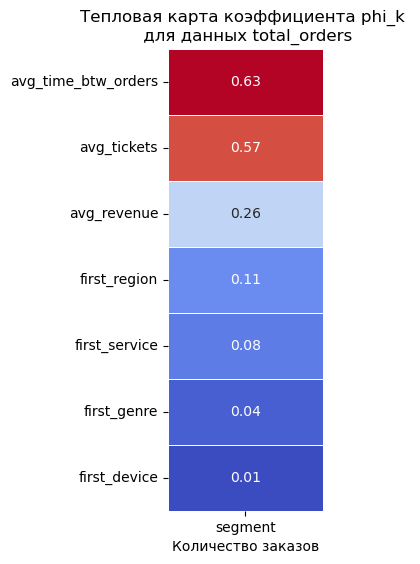

In [62]:
to_corr_columns = ['first_device', 'first_region', 'first_service', 'first_genre', 'segment', 
                   'avg_revenue', 'avg_tickets', 'avg_time_btw_orders']

corr = agg_df[to_corr_columns].phik_matrix(interval_cols=['avg_revenue', 'avg_tickets', 'avg_time_btw_orders'])

corr = corr.loc[corr.index != 'segment'][['segment']].sort_values(by='segment', ascending=False)
plt.figure(figsize=(2, 6))
sns.heatmap(corr,
            annot=True, 
            fmt='.2f', 
            cmap='coolwarm', 
            linewidths=0.5, 
            cbar=False)

plt.title('Тепловая карта коэффициента phi_k \n для данных total_orders')
plt.xlabel('Количество заказов')
plt.show()

После сегментации клиентов, связь количества заказов со временем между ними стала немного сильнее (0.6 -> 0.63)

Также намного явнее стала связь с количеством билетов в заказе. 

Заметной связи с регионом, билетным оператором, типом устройства и типом мероприятия не наблюдается

Проверим некоторые связи:

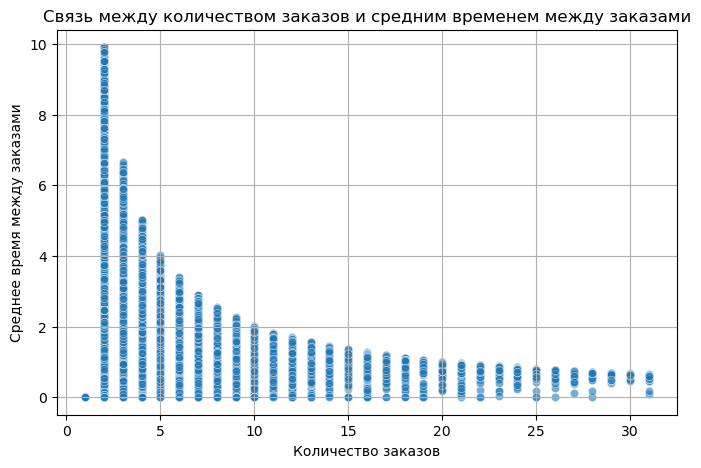

In [64]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=agg_df, x='total_orders', y='avg_time_btw_orders', alpha=0.6)

plt.title('Связь между количеством заказов и средним временем между заказами')
plt.xlabel('Количество заказов')
plt.ylabel('Среднее время между заказами')
plt.grid(True)
plt.show()

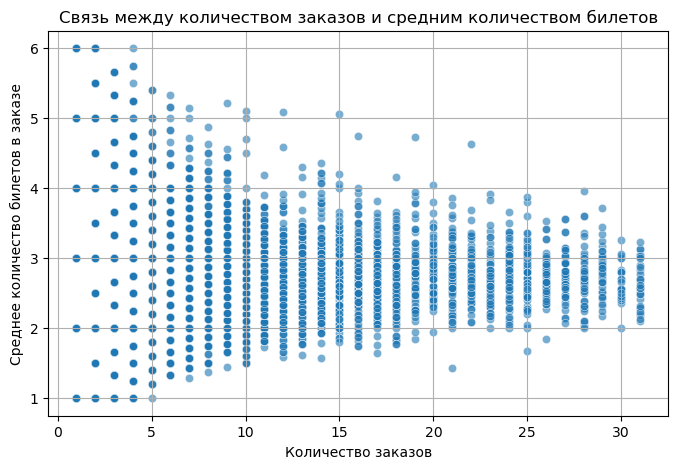

In [67]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=agg_df, x='total_orders', y='avg_tickets', alpha=0.6)

plt.title('Связь между количеством заказов и средним количеством билетов')
plt.xlabel('Количество заказов')
plt.ylabel('Среднее количество билетов в заказе')
plt.grid(True)
plt.show()

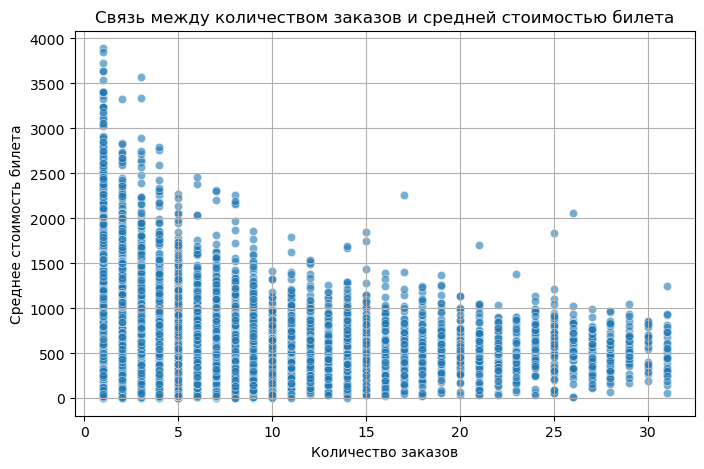

In [68]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=agg_df, x='total_orders', y='avg_revenue', alpha=0.6)

plt.title('Связь между количеством заказов и средней стоимостью билета')
plt.xlabel('Количество заказов')
plt.ylabel('Среднее стоимость билета')
plt.grid(True)
plt.show()

### 5. Общий вывод и рекомендации

**Информация о данных**

В ходе исследования проанализированы данные 20000 пользователей, совершивших 290000 заказов по данным сервиса Яндекс Афиша. Данные включали общую информацию о заказах, а также о мероприятиях. Акцент был на составлении портрета пользователся, склонного к повторному совершению заказа. 

В ходе предобработки были устранены выбросы и аномалии, создан новый столбец с выручкой, выраженной в рублях - для этого был использован дополнительный датасет с исторической информацией о курсе тенге к рублю.

Также, на основе данного датасета была проведена агрегация для составления профилей пользователей с информацией о первых заказах и статистических данных.

**Основные результаты анализа.** 
- В выборке более 20000 пользователей, среди которых около 60% совершили более 1 заказа и около 25% совершили 5 и более заказов.
- Больше всего пользователей совершило 2-3 заказа, а покупают по 3 билета за заказ.
- Пользователи, выбравшие выставки, театры и концерты в качестве первого мероприятия, немного чаще совершают повторные покупки
- Чем больше заказов у пользователя, тем меньше среднее время между ними
- Чем больше заказов, тем меньше разброс значений среднего количества билетов за заказ. Чем больше заказов, тем чаще пользователи покупают 2-3 билета за заказ
- Постоянные клиенты чаще покупают более дешевые билеты

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

**Рекомендации**
- Стоит обратить внимание на пользователей, выбравших выставки, театры и концерты в качестве первого мероприятия. Возможно следует продвигать мероприятия данного типа, проводить рекламные кампании.
- Пользователи, покупающие 2-3 билета за заказ, чаще становятся постоянными. Можно рассмотреть возможность внедрения скидок именно на такие количества билетов
- Чем больше заказов - тем меньше время между ними. Можно использовать рассылку уведомлений или внедрить программы лояльности, поощряющие регулярные покупки


### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

**Вставьте ссылку на проект в этой ячейке тетрадки перед отправкой проекта на ревью.**